In [12]:
import pandas as pd
import numpy as np
from nilearn import datasets
from nilearn.image import mean_img
from nilearn.plotting import plot_epi, plot_roi, show
from nilearn.image import concat_imgs
from nilearn.image import new_img_like
from nilearn.datasets import fetch_language_localizer_demo_dataset
from nilearn.glm.first_level import FirstLevelModel, first_level_from_bids
from nilearn.plotting import plot_design_matrix, plot_stat_map, show


In [2]:
data = fetch_language_localizer_demo_dataset()
data

[get_dataset_dir] Dataset found in C:\Users\mengl\nilearn_data\fMRI-language-localizer-demo-dataset


C:\Users\mengl\AppData\Local\Temp\ipykernel_35152\1783745816.py:1: DeprecationWarning: From version 0.13.0 this fetcherwill always return a Bunch.
Use `legacy_output=False` to start switch to this new behavior.
  data = fetch_language_localizer_demo_dataset()


('C:\\Users\\mengl\\nilearn_data\\fMRI-language-localizer-demo-dataset',
 ['C:\\Users\\mengl\\nilearn_data\\fMRI-language-localizer-demo-dataset\\.bidsignore',
  'C:\\Users\\mengl\\nilearn_data\\fMRI-language-localizer-demo-dataset\\CHANGES',
  'C:\\Users\\mengl\\nilearn_data\\fMRI-language-localizer-demo-dataset\\README',
  'C:\\Users\\mengl\\nilearn_data\\fMRI-language-localizer-demo-dataset\\access_data.py',
  'C:\\Users\\mengl\\nilearn_data\\fMRI-language-localizer-demo-dataset\\dataset_description.json',
  'C:\\Users\\mengl\\nilearn_data\\fMRI-language-localizer-demo-dataset\\derivatives\\dataset_description.json',
  'C:\\Users\\mengl\\nilearn_data\\fMRI-language-localizer-demo-dataset\\derivatives\\sub-01\\func\\sub-01_task-languagelocalizer_desc-confounds_regressors.tsv',
  'C:\\Users\\mengl\\nilearn_data\\fMRI-language-localizer-demo-dataset\\derivatives\\sub-01\\func\\sub-01_task-languagelocalizer_desc-preproc_bold.json',
  'C:\\Users\\mengl\\nilearn_data\\fMRI-language-locali

In [54]:
models, models_run_imgs, events_dfs, models_confounds = first_level_from_bids(
    dataset_path="C:\\Users\\mengl\\nilearn_data\\fMRI-language-localizer-demo-dataset",
    task_label="languagelocalizer",
    space_label="",
    sub_labels=["02"],
    img_filters=[("desc", "preproc")],
    n_jobs=2,
)

# Grab the first subject's model, functional file, and events DataFrame
standard_glm = models[0]
fmri_file = models_run_imgs[0][0]
events_df = events_dfs[0][0]

# We will use first_level_from_bids's parameters for the other models
glm_parameters = standard_glm.get_params()

# We need to override one parameter (signal_scaling)
# with the value of scaling_axis
glm_parameters["signal_scaling"] = standard_glm.signal_scaling

C:\Users\mengl\AppData\Local\Temp\ipykernel_35152\3659623845.py:1: UserWarning: 'StartTime' not found in file C:\Users\mengl\nilearn_data\fMRI-language-localizer-demo-dataset\derivatives\sub-01\func\sub-01_task-languagelocalizer_desc-preproc_bold.json.
  models, models_run_imgs, events_dfs, models_confounds = first_level_from_bids(


Fit model


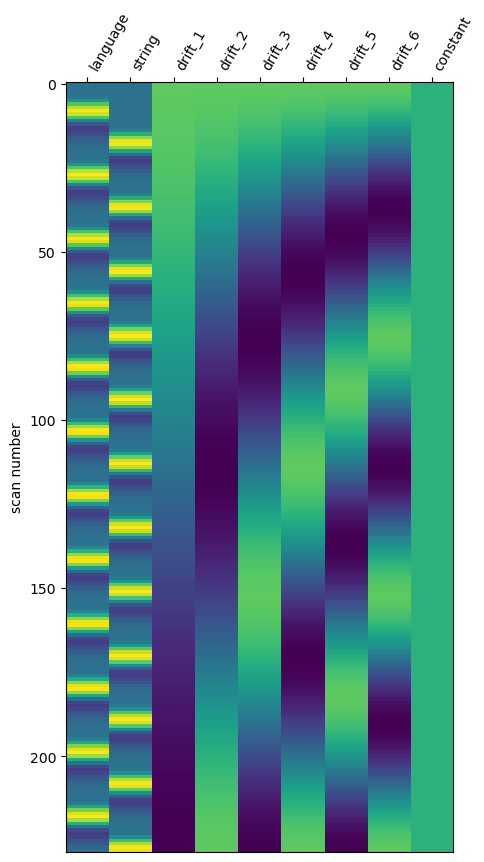

In [55]:
import matplotlib.pyplot as plt

print("Fit model")

standard_glm.fit(fmri_file, events_df)

# The standard design matrix has one column for each condition, along with
# columns for the confound regressors and drifts
fig, ax = plt.subplots(figsize=(5, 10))
plot_design_matrix(standard_glm.design_matrices_[0], axes=ax)
show()

In [56]:
print("Define and fit LSS")


def lss_transformer(events_df, row_number):
    """Label one trial for one LSS model.

    Parameters
    ----------
    df : pandas.DataFrame
        BIDS-compliant events file information.
    row_number : int
        Row number in the DataFrame.
        This indexes the trial that will be isolated.

    Returns
    -------
    df : pandas.DataFrame
        Update events information, with the select trial's trial type isolated.
    trial_name : str
        Name of the isolated trial's trial type.
    """
    events_df = events_df.copy()

    # Determine which number trial it is *within the condition*
    trial_condition = events_df.loc[row_number, "trial_type"]
    trial_type_series = events_df["trial_type"]
    trial_type_series = trial_type_series.loc[
        trial_type_series == trial_condition
    ]
    trial_type_list = trial_type_series.index.tolist()
    trial_number = trial_type_list.index(row_number)

    # We use a unique delimiter here (``__``) that shouldn't be in the
    # original condition names.
    # Technically, all you need is for the requested trial to have a unique
    # 'trial_type' *within* the dataframe, rather than across models.
    # However, we may want to have meaningful 'trial_type's (e.g., 'Left_001')
    # across models, so that you could track individual trials across models.
    trial_name = f"{trial_condition}__{trial_number:03d}"
    events_df.loc[row_number, "trial_type"] = trial_name
    return events_df, trial_name





Define and fit LSS


In [57]:
# Loop through the trials of interest and transform the DataFrame for LSS
lss_beta_maps = []
lss_design_matrices = []

for i_trial in range(events_df.shape[0]):
    lss_events_df, trial_condition = lss_transformer(events_df, i_trial)

    # Compute and collect beta maps
    lss_glm = FirstLevelModel(**glm_parameters)
    lss_glm.fit(fmri_file, lss_events_df)

    # We will save the design matrices across trials to show them later
    lss_design_matrices.append(lss_glm.design_matrices_[0])

    beta_map = lss_glm.compute_contrast(
        trial_condition,
        output_type="effect_size",
    )

    lss_beta_maps.append(beta_map)


In [58]:
lss_beta_maps = concat_imgs(lss_beta_maps)
lss_beta_maps.get_fdata().shape

(45, 53, 43, 24)

0     language
1       string
2     language
3       string
4     language
5       string
6     language
7       string
8     language
9       string
10    language
11      string
12    language
13      string
14    language
15      string
16    language
17      string
18    language
19      string
20    language
21      string
22    language
23      string
Name: trial_type, dtype: object


<Axes: >

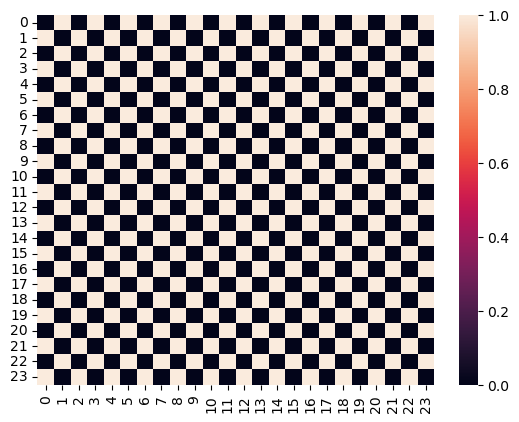

In [70]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import pairwise_distances
print(events_df["trial_type"])
# Convert to numpy 2D array
arr = np.array(events_df["trial_type"].map({"language":0,"string":1})).reshape(-1,1)

# pairwise hamming distance
beh_RDM = pairwise_distances(arr, metric="hamming")
import seaborn as sns
sns.heatmap(beh_RDM)

In [60]:
from nilearn.datasets import fetch_atlas_aal
from nilearn.image import resample_to_img
AAL_atlas = fetch_atlas_aal()
print(AAL_atlas.labels)

AAL_resampled=resample_to_img(AAL_atlas.maps,lss_beta_maps,interpolation="nearest")
index = np.array(AAL_atlas.indices)[np.array(AAL_atlas.labels)=='Frontal_Inf_Tri_L']
print(index)

[get_dataset_dir] Dataset found in C:\Users\mengl\nilearn_data\aal_SPM12
['Precentral_L', 'Precentral_R', 'Frontal_Sup_L', 'Frontal_Sup_R', 'Frontal_Sup_Orb_L', 'Frontal_Sup_Orb_R', 'Frontal_Mid_L', 'Frontal_Mid_R', 'Frontal_Mid_Orb_L', 'Frontal_Mid_Orb_R', 'Frontal_Inf_Oper_L', 'Frontal_Inf_Oper_R', 'Frontal_Inf_Tri_L', 'Frontal_Inf_Tri_R', 'Frontal_Inf_Orb_L', 'Frontal_Inf_Orb_R', 'Rolandic_Oper_L', 'Rolandic_Oper_R', 'Supp_Motor_Area_L', 'Supp_Motor_Area_R', 'Olfactory_L', 'Olfactory_R', 'Frontal_Sup_Medial_L', 'Frontal_Sup_Medial_R', 'Frontal_Med_Orb_L', 'Frontal_Med_Orb_R', 'Rectus_L', 'Rectus_R', 'Insula_L', 'Insula_R', 'Cingulum_Ant_L', 'Cingulum_Ant_R', 'Cingulum_Mid_L', 'Cingulum_Mid_R', 'Cingulum_Post_L', 'Cingulum_Post_R', 'Hippocampus_L', 'Hippocampus_R', 'ParaHippocampal_L', 'ParaHippocampal_R', 'Amygdala_L', 'Amygdala_R', 'Calcarine_L', 'Calcarine_R', 'Cuneus_L', 'Cuneus_R', 'Lingual_L', 'Lingual_R', 'Occipital_Sup_L', 'Occipital_Sup_R', 'Occipital_Mid_L', 'Occipital_Mid_

C:\Users\mengl\AppData\Local\Temp\ipykernel_35152\710973961.py:6: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  AAL_resampled=resample_to_img(AAL_atlas.maps,lss_beta_maps,interpolation="nearest")
c:\Users\mengl\miniconda3\Lib\site-packages\nilearn\image\resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


In [61]:
mask = AAL_resampled.get_fdata()==int(index[0])
ROI_data = lss_beta_maps.get_fdata()[mask].transpose()
ROI_data.shape

(24, 201)

<Axes: >

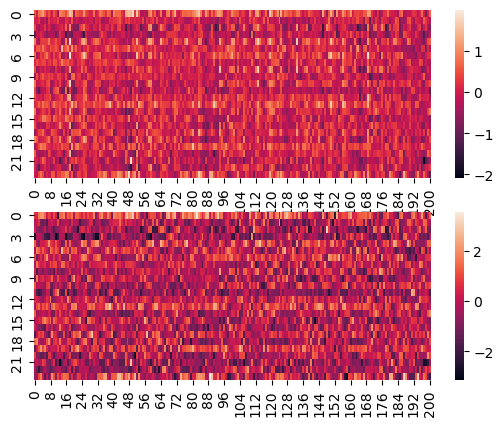

In [62]:
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
preprocess_pipeline = make_pipeline(VarianceThreshold(threshold=0),StandardScaler())
ROI_data_preproc = preprocess_pipeline.fit_transform(ROI_data)
fig, axes = plt.subplots(2,1)
sns.heatmap(ROI_data, ax=axes[0])
sns.heatmap(ROI_data_preproc, ax=axes[1])


(24, 24)


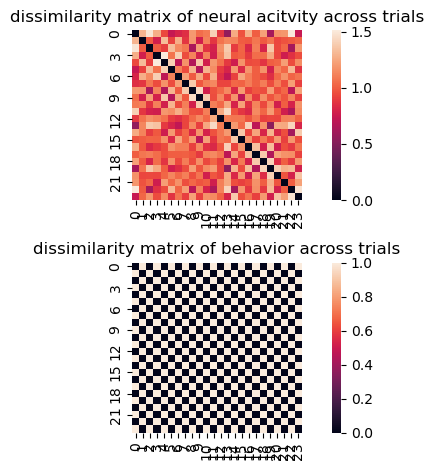

In [63]:
# calculate trial pairwise distance
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from scipy.spatial.distance import pdist, squareform

# neural_RDM = 1-np.corrcoef(ROI_data_preproc)
# neural_RDM = euclidean_distances(ROI_data_preproc)
neural_RDM = 1-cosine_similarity(ROI_data_preproc)

print(RDM_neural.shape)

plt.close('All')
fig, axes = plt.subplots(2,1)
sns.heatmap(neural_RDM, ax=axes[0],square=True)
sns.heatmap(beh_RDM, ax=axes[1],square=True)
axes[0].set_title("dissimilarity matrix of neural acitvity across trials")
axes[1].set_title("dissimilarity matrix of behavior across trials")
fig.tight_layout()

In [64]:
# extract half matrix of the neural RDM
upper_triangle_indices = np.triu_indices(neural_RDM.shape[0], k=1)
neural_RDM_upper=neural_RDM[upper_triangle_indices]
print(neural_RDM_upper.shape)
# extract half matrix of the behavioral RDM
beh_RDM_upper = beh_RDM[upper_triangle_indices]


(276,)


In [65]:
# calculate the correlation of behavioral and neural RDM
r_value = np.corrcoef(neural_RDM_upper, beh_RDM_upper)
print(r_value)

[[1.         0.44883641]
 [0.44883641 1.        ]]


In [66]:
import statsmodels.api as sm
ols_model = sm.OLS(neural_RDM_upper,sm.add_constant(beh_RDM_upper)).fit()
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.201
Model:                            OLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                     69.12
Date:                Sun, 28 Sep 2025   Prob (F-statistic):           4.36e-15
Time:                        11:08:59   Log-Likelihood:                 84.067
No. Observations:                 276   AIC:                            -164.1
Df Residuals:                     274   BIC:                            -156.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9486      0.016     60.857      0.000       0.918       0.979
x1             0.1794      0.022      8.314      0.000       0.137       0.222
==============================================================================
Omnibus:                        2.681   Durbin-Watson:                   2.278
Prob(Omnibus):                  0.262   Jarque-Bera (JB):                2.799
Skew:                           0.047   Prob(JB):                        0.247
Kurtosis:                       3.484   Cond. No.                         2.67
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [67]:
r_nii = np.zeros(AAL_resampled.shape)

In [68]:
for label in AAL_atlas.labels:
    index = np.array(AAL_atlas.indices)[np.array(AAL_atlas.labels)==label]
    
    mask = AAL_resampled.get_fdata()==int(index[0])
    ROI_data = lss_beta_maps.get_fdata()[mask].transpose()

    preprocess_pipeline = make_pipeline(VarianceThreshold(threshold=0),StandardScaler())
    try:
        ROI_data_preproc = preprocess_pipeline.fit_transform(ROI_data)
    except:
        continue
    neural_RDM = 1-cosine_similarity(ROI_data_preproc)
    neural_RDM_upper=neural_RDM[upper_triangle_indices]
    
    r_value = np.corrcoef(neural_RDM_upper, beh_RDM_upper)
    # save r_value
    r_nii[mask]=r_value[0,1]

final_r_value_img = new_img_like(AAL_resampled, r_nii)


c:\Users\mengl\miniconda3\Lib\site-packages\numpy\core\fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



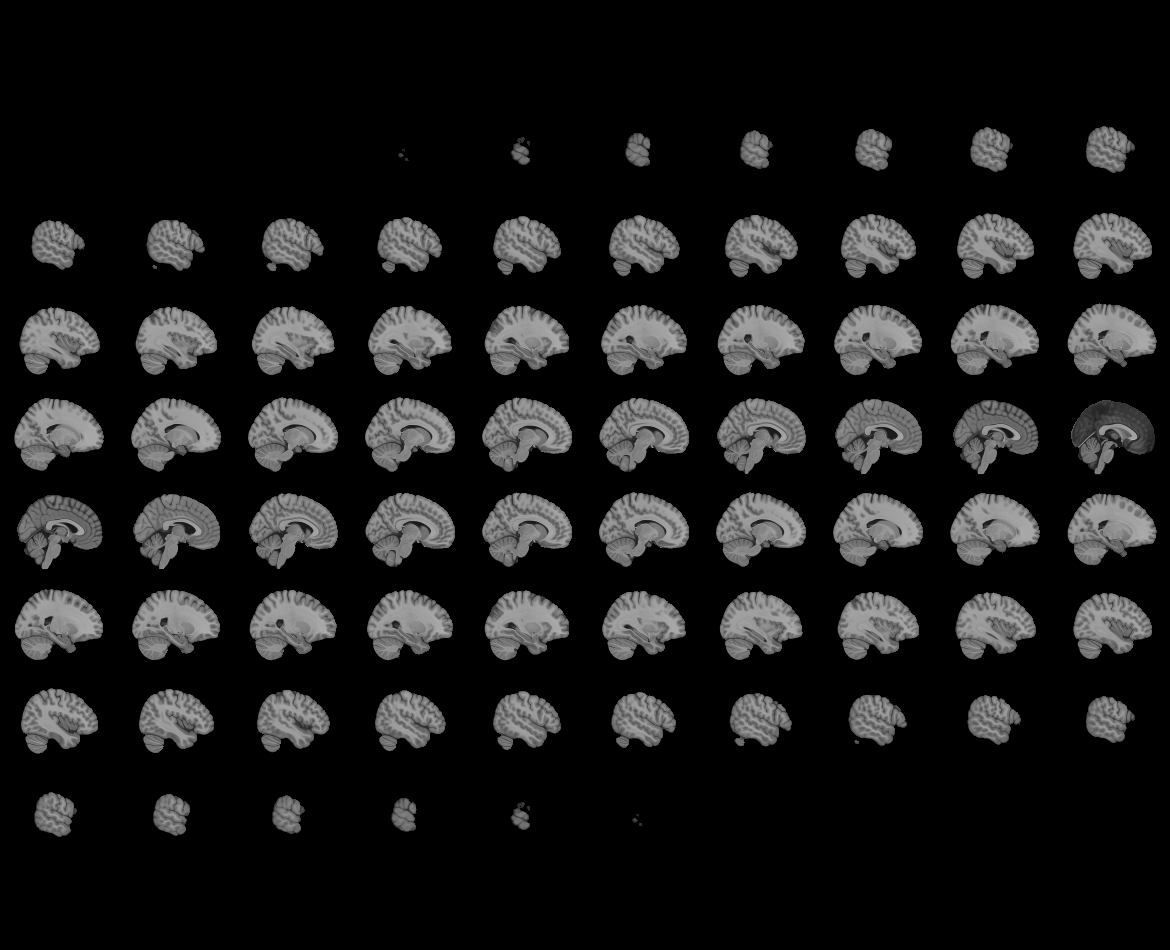
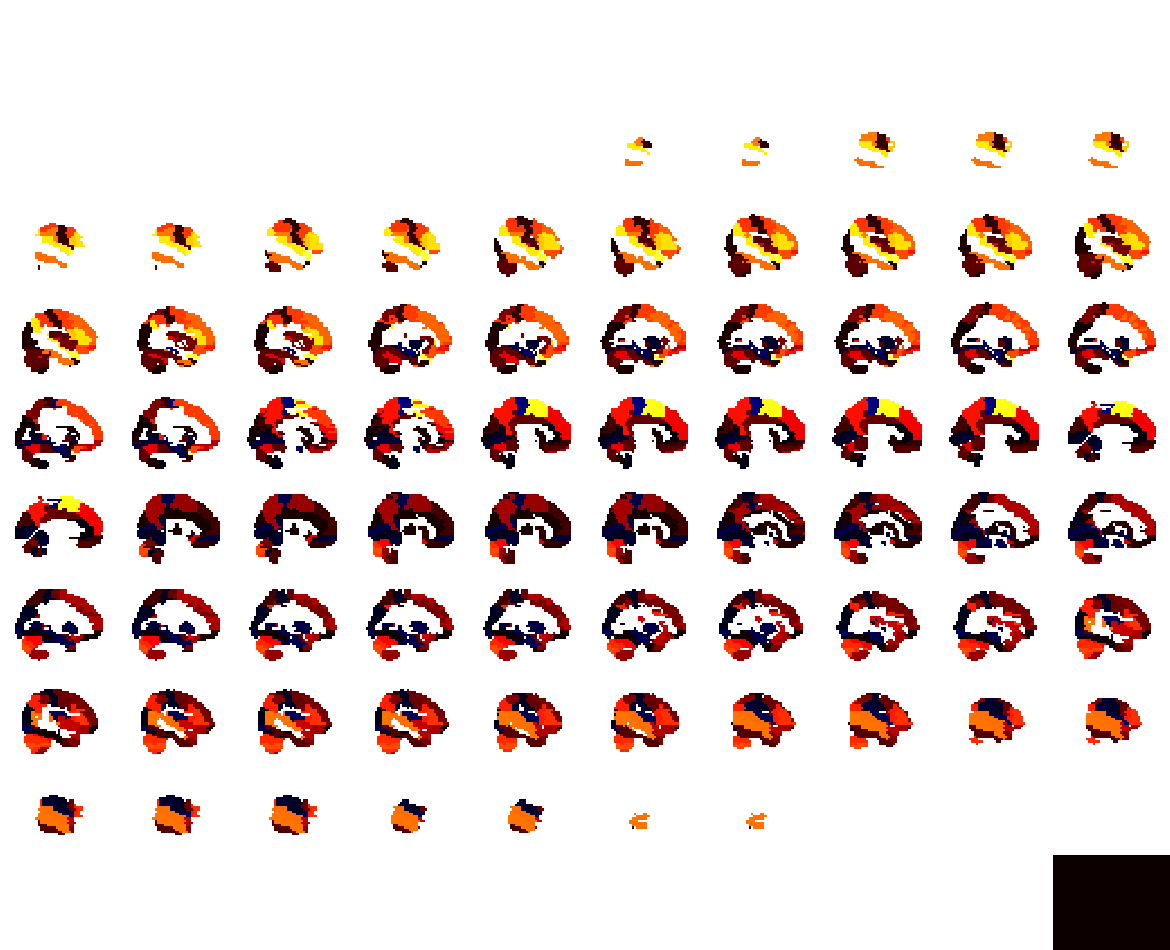

In [69]:
from nilearn.plotting import view_img
view_img(final_r_value_img,resampling_interpolation="nearest")